In [1]:
from pylab import *
import numpy as np

# HW 12: Radiative Transfer Modeling

We've talked about disk models and the general trends we can expect from irradiated sources. We want to build our understanding of how to interpret dust continuum images and what they can tell us about the underlying profile. In order to do this, we're going to start practicing using MCMC radiative transfer methods like RADMC-3D to build our intuition and give us a way to build more complex models. 
Whenever we use astronomical software, we want to be able to understand and contextualize its results and performance. We can use analytic models to validate results from more complicated setups and guide our interpretation. 

## I: Analytic Model
### part a.
Using the fiducial model we discussed in class, define functions for a radiative midplane temperature profile, the sound speed, Keplerian velocity, surface density profile, and gas scale height (as a function of radius). 

In [ ]:
kb = 1.3807e-16 #Boltzmann constant cgs
Gconv = 6.6743e-8 # cgs
sigsb = 5.671e-5 #Stefan Boltzmann constant
c = 2.99792458e10 # speed of light cgs
h = 6.6260755e-27 #planck constant cgs
mh = 1.67e-24 # mass of hydrogen cgs
pc = 3.086e18 #parsecs in cm
au = 1.49598e13 #au in cm
Msun = 1.989e33 #msun in grams

def T_rad(r,Ts,Rs,f_A=0.5,r0=1.):
    """return radiative temperature profile """ 
    return Ts * (Rs/(r*au))**0.5 * f_A**0.25

def Sigma_gas(r, rd, Md, r0=1.,p=1):
    """return gas surface density profile """ 
    sig0 = Md/(2*pi*rd**2) * (2-p)
    return sig0 * (r/r0)**(-p) * np.exp(-(r/rd)**(2-p))

def cs_rad(r, Ts, Rs, r0=1.):
    """return sound speed profile """
    return np.sqrt(kb*T_rad(r, Ts, Rs)/(2.3*mh))

def vkep(r,r0=1):
    """return keplerian velocity profile """
    return np.sqrt(Gconv*Msun/(r*au))

def h(r, Ts, Rs, r0=1):
    """return H/R (aspect ratio) profile """
    return cs_rad(r, Ts, Rs)/vkep(r)

### part b
Now you're going to do some reverse engineering. RADMC-3D has an extensive list of example protoplanetary disk models in the ```examples``` directory of the code. There's a lot of input files that need to be generated to run a [dust radiative transfer model](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_radmc3d/dustradtrans.html#overview-of-input-data-for-dust-radiative-transfer), but by running ```python problem_setup.py``` in one of the example directories, the script will generate those files for you for a set of default assumptions. 

We're building a simple radiative transfer model off of one of the examples (the computational astrophysict's tried and true way to learn how to run a numerical model is to take the closest working example to your desired situation and start by modifying it! always always always look at the examples!)

I've used ```run_ppdisk_simple_2``` as our base model. I've included a folder called ```run_ppdisk_spf1```.  If you look at the contents of ```problem_setup.py``` in this directory you'll see a list of input parameters, see how they're used to define the grid the simulation uses, the disk surface density. You should recognize many of the fiducial parameters in the setup of this file. The main difference with what we've discussed in class is that this model uses two populations of dust (big and small) - in which 99% ```fracbig``` of grains are in large grains, which are settled to the midplane to a fraction of the gas scale height,  compared to the remaining 1% of small grains which remain coupled to the gas and thus share the gas scale height. This example has corresponding dust opacities for each population. Then the second half of the script writes all the input files for RADMC-3D based on the parameters in the model. 

Now, I want you to read through ```problem_setup.py``` and identify what the fiducial parameters used in the model are for

**The stellar parameters**  
$M_s$    
$T_s$    
$R_s$  
**The disk parameters**  
$\Sigma(r_0)$  
$r_d$ - the disk radius  
$M_{d,gas}$ - the total disk gas mass   
$\epsilon $ - the dust to gas mass ratio   
$H/R(r_0)$ - the aspect ratio at $r_0 = 1 \ \mathrm{au}$

etc.

Use these parameters and your defined functions to deduce and plot what the input profiles look like for $\Sigma(r)$ for the dust and gas, $T(r), c_s(r), v_k(r), H(r)$

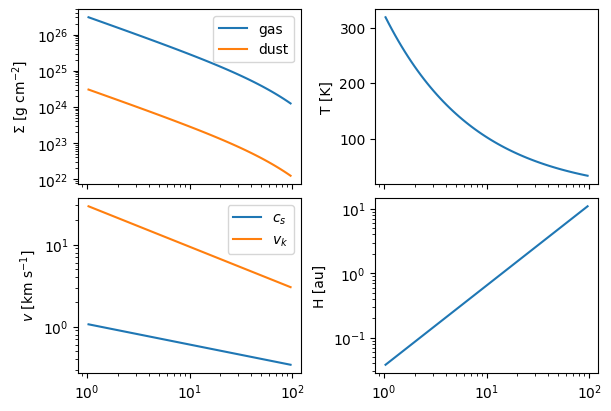

In [ ]:
# radial grid from the problem setup  
rin = 1.
rout = 100.
nr = 64

f,ax = subplots(2,2, constrained_layout=True, dpi=100,sharex=True)


ri = np.logspace(np.log10(rin),np.log10(rout),nr+1)
rc = 0.5 * (ri[0:nr] + ri[1:nr+1])

Ts = 4000 
Rs = 2*6.96e10 

rd_fid = 100
d2g_fid = 0.01

sig_gas = Sigma_gas(rc, rd=rd_fid, Md=1e-2*Msun)
sig_dust = sig_gas * d2g_fid

ax[0,0].loglog(rc, sig_gas, label='gas')
ax[0,0].loglog(rc, sig_dust, label='dust')
ax[0,0].set_ylabel(r'$\Sigma \ \mathrm{[g \ cm^{-2}]}$')

T_init = T_rad(rc, Ts=Ts, Rs=Rs)
ax[0,1].semilogx(rc, T_init)
ax[0,1].set_ylabel('T [K]')

cmtokm = 10**-5
cs_init = cs_rad(rc, Ts=Ts, Rs=Rs)*cmtokm
vk_init = vkep(rc)*cmtokm
ax[1,0].loglog(rc, cs_init, label=r'$c_s$')
ax[1,0].loglog(rc, vk_init, label=r'$v_k$')
ax[1,0].set_ylabel(r'$v \ \mathrm{[km\ s^{-1}]}$')

H_init = h(rc, Ts=Ts, Rs=Rs)*rc
ax[1,1].loglog(rc, H_init)
ax[1,1].set_ylabel('H [au]')

ax[0,0].legend()
ax[1,0].legend()

Once you're happy with the model you've reverse engineered, you can solve for the cylindrical coordinate slice r-z, and plot the 2D distribution for the input dust density below assuming HSEQ:

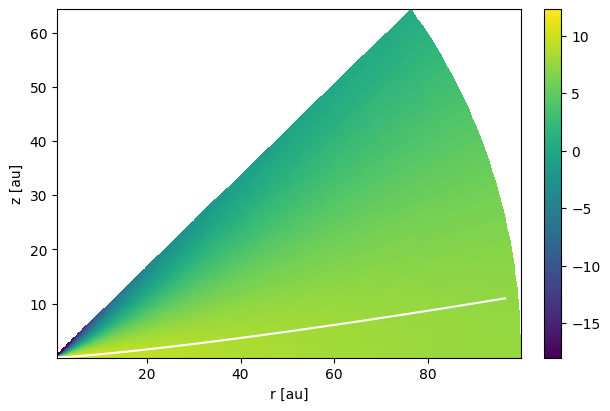

In [34]:
### polar grid from problem setup
ntheta   = 32
thetaup  = np.pi*0.5 - 0.7e0
thetai   = np.linspace(thetaup,0.5e0*np.pi,ntheta+1) #pi/2 = midplane 
thetac   = 0.5 * ( thetai[0:ntheta] + thetai[1:ntheta+1] )

### turning coordinates into square grid
r, th = np.meshgrid(rc,thetac,indexing='ij')
### returning z vs. r from cylindrical coordinates
r_mid = r*np.sin(th) #cylindrical coordinate value
z = r*np.cos(th) #cylindrical coordinate value

H_2d = np.expand_dims(H_init,axis=1)
rho_mid = np.expand_dims(sig_dust/(np.sqrt(2*pi)*H_init*au),axis=1)
rho_hseq = rho_mid *np.exp(-0.5*(z/H_2d)**2)

f,ax=subplots(1,constrained_layout=True, dpi=100)
im = ax.pcolormesh(r_mid, z, np.log10(rho_hseq),vmin=-18)
ax.plot(rc,H_init,color='white')

ax.set_xlabel('r [au]')
ax.set_ylabel('z [au]')
colorbar(im, ax=ax)

## I: Numerical Model
Now we can try running the problem setup and generating the input file. Within the ```run_ppdisk_spf1``` directory, we can run the problem generator. You can use the command line or use the ```os``` library below to interface with the command line through the notebook.

If everything went well, you should see some input files (with the extension ```.inp```)  were written in the directory.

In [25]:
import os
pathtodir = './run_ppdisk_spf1/'
os.chdir(pathtodir)
os.system('python problem_setup.py')

FileNotFoundError: [Errno 2] No such file or directory: './run_ppdisk_spf1/'

### part a.
Now we can load in the data from what radmc3d produced and check against the fiducial model you created. Below I've copied over some functions from the file providing some default python tools: ```radmc3d-2.0/python/radmc3d_tools/simple_read.py``` which you can load in by executing the cell below.

In [26]:
import glob

class simplereaddataobject(object):
    """
    Generic data object for the RADMC-3D simpleread.py functions.
    """
    def __init__(self,datatype):
        self.datatype = datatype

def read_grid():
    """
    Reading the amr_grid.inp file, but only for regular grids (not for octree ones). 

    ARGUMENTS:
      None

    RETURNS:
      Data object containing:

        .nx          Nr of cells in x direction (in spherical coordinates this is the r-direction)
        .ny          Nr of cells in y direction (in spherical coordinates this is the theta-direction)
        .nz          Nr of cells in z direction (in spherical coordinates this is the phi-direction)
        .nxi etc     The same as .nx etc, but now +1, giving the number of cell interfaces
        .crd_sys     String indicating the coordinate system ('car' or 'sph')
        .x,.y,.z     The x, y and z grid cell center locations
        .xi,.yi,.zi  The x, y and z grid cell interface locations (each array 1 longer than the x, y, z ones)

    """
    grid  = simplereaddataobject('grid')
    fname = 'amr_grid.inp'
    print('Reading '+fname)
    data  = np.fromfile(fname, count=-1, sep=" ", dtype=np.float64)

    # Read the header
    hdr   = np.array(data[:10], dtype=np.int)
    data  = data[10:]

    # Check the file format
    if hdr[0] != 1:
        msg = 'Unknown format number in amr_grid.inp'
        raise RuntimeError(msg)
    if hdr[2] < 100:
        grid.crd_sys = 'car'
    elif (hdr[2] >= 100) & (hdr[2] < 200):
        grid.crd_sys = 'sph'
    else:
        raise ValueError('Unsupported coordinate system identification in the ' + fname + ' file.')

    # Get active dimensions
    grid.act_dim = hdr[4:7]

    # Get the number of cells in each dimensions
    grid.nx = hdr[7]
    grid.ny = hdr[8]
    grid.nz = hdr[9]
    grid.nxi, grid.nyi, grid.nzi = grid.nx + 1, grid.ny + 1, grid.nz + 1

    # Get the cell interfaces
    grid.xi = data[:grid.nxi]
    data = data[grid.nxi:]
    grid.yi = data[:grid.nyi]
    data = data[grid.nyi:]
    grid.zi = data[:grid.nzi]

    # Compute the cell centers
    if grid.crd_sys == 'car':
        grid.x = (grid.xi[0:grid.nx] + grid.xi[1:grid.nx + 1]) * 0.5
        grid.y = (grid.yi[0:grid.ny] + grid.yi[1:grid.ny + 1]) * 0.5
        grid.z = (grid.zi[0:grid.nz] + grid.zi[1:grid.nz + 1]) * 0.5
    else:
        grid.x = np.sqrt(grid.xi[0:grid.nx] * grid.xi[1:grid.nx + 1])
        grid.y = (grid.yi[0:grid.ny] + grid.yi[1:grid.ny + 1]) * 0.5
        grid.z = (grid.zi[0:grid.nz] + grid.zi[1:grid.nz + 1]) * 0.5

    # Now return the grid object
    return grid
    
def read_dustdens(indexorder='fortran'):
    """
    Reading the dust_density.inp file, but only for regular grids, and only
    for text data format (not binary).

    ARGUMENTS:
      indexorder        If 'fortran' then converting array to fortran 
                        index order (default). Else use Python/C order.

    RETURNS:
      Data object containing:

        .grid           A grid object (see read_grid())
        .rhodust        An array with the dust density values (in g/cm^3)
    """
    grid      = read_grid()
    dustdens  = simplereaddataobject('dust_density')
    dustdens.grid = grid
    fname     = 'dust_density.inp'
    print('Reading '+fname)
    data      = np.fromfile(fname, count=-1, sep=" ", dtype=np.float64)
    
    # Read the header
    hdr       = np.array(data[:3], dtype=np.int)
    data      = data[3:]

    # Check the file format
    if hdr[0] != 1:
        msg = 'Unknown format number in dust_density.inp'
        raise RuntimeError(msg)

    # Get the number of cells, and check against
    nrcells = grid.nx*grid.ny*grid.nz
    if(hdr[1]!=nrcells):
        msg = 'Number of grid cells in dust_density.inp inconsistent with amr_grid.inp'
        raise RuntimeError(msg)

    # Get the number of dust species
    dustdens.nrspec = hdr[2]

    # Convert the rest of the data to the proper shape
    data = np.reshape(data, [dustdens.nrspec, grid.nz, grid.ny, grid.nx])

    # If indexorder is set to 'fortran', then the inner index of the array
    # should be left (even though in Python the inner index is right). This
    # is to assure that the index order in the Python arrays is the same as
    # in the RADMC-3D code. But by setting indexorder to anything else, you
    # can keep Python natural order (which is equal to C index order), in
    # which the inner index is the rightmost index.
    if indexorder=='fortran':
        data = np.swapaxes(data, 0, 3)
        data = np.swapaxes(data, 1, 2)

    # Now add this to the object
    dustdens.rhodust = data

    # Return the dustdens object
    return dustdens

def read_dusttemp(indexorder='fortran'):
    """
    Reading the dust_temperature.dat file, but only for regular grids, and only
    for text data format (not binary).

    ARGUMENTS:
      indexorder        If 'fortran' then converting array to fortran 
                        index order (default). Else use Python/C order.

    RETURNS:
      Data object containing:

        .grid           A grid object (see read_grid())
        .dusttemp       An array with the dust temperature values (in K)
    """
    grid      = read_grid()
    dusttemp  = simplereaddataobject('dust_temperature')
    dusttemp.grid = grid
    fname     = 'dust_temperature.dat'
    print('Reading '+fname)
    data      = np.fromfile(fname, count=-1, sep=" ", dtype=np.float64)
    
    # Read the header
    hdr       = np.array(data[:3], dtype=np.int)
    data      = data[3:]

    # Check the file format
    if hdr[0] != 1:
        msg = 'Unknown format number in dust_temperature.inp'
        raise RuntimeError(msg)

    # Get the number of cells, and check against
    nrcells = grid.nx*grid.ny*grid.nz
    if(hdr[1]!=nrcells):
        msg = 'Number of grid cells in dust_temperature.inp inconsistent with amr_grid.inp'
        raise RuntimeError(msg)

    # Get the number of dust species
    dusttemp.nrspec = hdr[2]

    # Convert the rest of the data to the proper shape
    data = np.reshape(data, [dusttemp.nrspec, grid.nz, grid.ny, grid.nx])

    # If indexorder is set to 'fortran', then the inner index of the array
    # should be left (even though in Python the inner index is right). This
    # is to assure that the index order in the Python arrays is the same as
    # in the RADMC-3D code. But by setting indexorder to anything else, you
    # can keep Python natural order (which is equal to C index order), in
    # which the inner index is the rightmost index.
    if indexorder=='fortran':
        data = np.swapaxes(data, 0, 3)
        data = np.swapaxes(data, 1, 2)

    # Now add this to the object
    dusttemp.dusttemp = data

    # Return the dusttemp object
    return dusttemp

def read_image(indexorder='fortran'):
    """
    Reading the image.out file.

    ARGUMENTS:
      indexorder        If 'fortran' then converting array to fortran 
                        index order (default). Else use Python/C order.

    RETURNS:
      Data object containing:

        .freq           Frequency at which the image is taken
        .image          An array with the image intensity in erg/(s.cm^2.Hz.ster)
    """
    pc        = 3.08572e18     # Parsec                  [cm]
    cc        = 2.99792458e10  # Light speed             [cm/s]
    image     = simplereaddataobject('image')
    fname     = 'image.out'
    print('Reading '+ fname)
    with open(fname, 'r') as rfile:
        dum = ''

        # Format number
        iformat = int(rfile.readline())

        # Nr of pixels
        dum = rfile.readline()
        dum = dum.split()
        image.nx = int(dum[0])
        image.ny = int(dum[1])

        # Nr of frequencies
        image.nfreq = int(rfile.readline())
        image.nwav = image.nfreq

        # Pixel sizes
        dum = rfile.readline()
        dum = dum.split()
        image.sizepix_x = float(dum[0])
        image.sizepix_y = float(dum[1])

        # Wavelength of the image
        image.wav = np.zeros(image.nwav, dtype=np.float64)
        for iwav in range(image.nwav):
            image.wav[iwav] = float(rfile.readline())
        image.freq = cc / image.wav * 1e4

        # Read the rest of the data
        data = np.fromfile(rfile, count=-1, sep=" ", dtype=np.float64)
        
    # Convert the rest of the data to the proper shape
    if iformat == 1:
        # We have a normal total intensity image
        image.stokes = False
        data = np.reshape(data, [image.nfreq, image.ny, image.nx])
        if indexorder=='fortran':
            data = np.swapaxes(data, 0, 2)

    elif iformat == 3:
        # We have the full stokes image
        image.stokes = True
        data = np.reshape(data, [image.nfreq, 4, image.ny, image.nx])
        if indexorder=='fortran':
            data = np.swapaxes(data, 0, 3)
            data = np.swapaxes(data, 1, 2)

    else:
        msg = 'Unknown format number in image.out'
        raise ValueError(msg)

    # Add this to the object
    image.image = data
    
    # Conversion from erg/s/cm/cm/Hz/ster to Jy/pixel
    conv = image.sizepix_x * image.sizepix_y / pc**2. * 1e23
    image.imageJyppix = image.image * conv
    
    # Create the x and y axes in units of cm
    image.x = ((np.arange(image.nx, dtype=np.float64) + 0.5) - image.nx / 2) * image.sizepix_x
    image.y = ((np.arange(image.ny, dtype=np.float64) + 0.5) - image.ny / 2) * image.sizepix_y
    
    # Return object
    return image

def read_spectrum(dpc=1.):
    """
    Reading the spectrum.out file.

    ARGUMENTS:
      dpc               Distance of observer in parsec (default=1)

    RETURNS:
      Data object containing:

        .wav            Wavelength array of the spectrum in micron
        .freq           Frequency array of the spectrum in Hertz
        .fnu            An array with the flux F_nu at dpc parsec in erg/(s.cm^2.Hz)
    """
    cc        = 2.99792458e10  # Light speed             [cm/s]
    spectrum  = simplereaddataobject('spectrum')
    fname     = 'spectrum.out'
    print('Reading '+ fname)
    with open(fname, 'r') as rfile:
        # Read the format number
        iformat = int(rfile.readline())

        # Read the number of wavelengths
        spectrum.nwav = int(rfile.readline())
        spectrum.freq = spectrum.nwav

        # Read a blank line
        dum = rfile.readline()

        # Read the rest of the data
        data = np.fromfile(rfile, count=-1, sep=" ", dtype=np.float64)

    # Reshape the spectrum
    data          = np.reshape(data, [spectrum.nwav, 2])
    spectrum.wav  = data[:,0]
    spectrum.freq = 1e4 * cc / spectrum.wav
    spectrum.fnu  = data[:,1]

    # Rescale spectrum to other distance
    spectrum.fnu /= dpc**2

    # Return the spectrum
    return spectrum

def read_dustkappa(species=None):
    """
    Reading a dust opacity file (but only the basic dustkappa_*.inp type,
    not the dustkapscatmat_*.inp type).

    ARGUMENTS:
      species           The dust species: Reading dustkappa_<species>.inp
                        If unspecified, read_dustkappa will search for such a file.
                        If it finds a single one, it will read that. Otherwise it
                        will request you to specify species.

    RETURNS:
      Data object containing:

        .wav            Wavelength array of the spectrum in micron
        .freq           Frequency array of the spectrum in Hertz
        .kappa_abs      Absorption opacity in cm^2/gram-of-dust
        .kappa_sca      Scattering opacity in cm^2/gram-of-dust
        .kappa_g        The g-coefficient (between -1 and 1) for non-isotropic scattering
    """
    cc        = 2.99792458e10  # Light speed             [cm/s]

    # Find which dust opacity to read
    if species is None:
        fnames = glob.glob('dustkappa_*.inp')
        if len(fnames)==0:
            msg = 'No file of type dustkappa_*.inp is found in this directory.'
            raise RuntimeError(msg)
        if len(fnames)>1:
            msg = 'More than one file of type dustkappa_*.inp is found in this directory. Please specify the name of the dust species as keyword species.'
            raise RuntimeError(msg)
        species = fnames[0]
    if species[0:10]=='dustkappa_': species = species[10:]
    if species[-4:]=='.inp': species = species[:-4]

    # Read that dust opacity
    dustkappa = simplereaddataobject('dustkappa')
    fname     = 'dustkappa_'+species+'.inp'
    print('Reading '+ fname)
    with open(fname, 'r') as rfile:
        # Check the file format (skipping comments)
        iformat_str = rfile.readline()
        while iformat_str[0]=='#':
            iformat_str = rfile.readline()
        iformat = int(iformat_str)

        # Read the number of wavelength points
        dustkappa.nwav = int(rfile.readline())
        dustkappa.freq = dustkappa.nwav

        # Now read the rest of the data
        data = np.fromfile(rfile, count=-1, sep=" ", dtype=np.float64)

    # Reshape the data
    if iformat==1:
        data = np.reshape(data, [dustkappa.nwav, 2])
    elif iformat==2:
        data = np.reshape(data, [dustkappa.nwav, 3])
    elif iformat==3:
        data = np.reshape(data, [dustkappa.nwav, 4])
    else:
        msg = 'Format number of kappa file not known'
        raise RuntimeError(msg)

    # Extract the information
    dustkappa.wav        = data[:,0]
    dustkappa.freq       = 1e4 * cc / dustkappa.wav
    dustkappa.kappa_abs  = data[:,1]
    if iformat>1:
        dustkappa.kappa_sca = data[:,2]
    if iformat>2:
        dustkappa.kappa_g = data[:,3]

    # Return dustkappa
    return dustkappa


If you reverse engineered the model correctly, the analytic prediction below should match what you read in from the input file!

Reading amr_grid.inp
Reading dust_density.inp


/var/folders/ll/nyl1hb0d1kd57xb5xj7nh34m0000gn/T/ipykernel_16023/616824347.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hdr   = np.array(data[:10], dtype=np.int)
/var/folders/ll/nyl1hb0d1kd57xb5xj7nh34m0000gn/T/ipykernel_16023/616824347.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

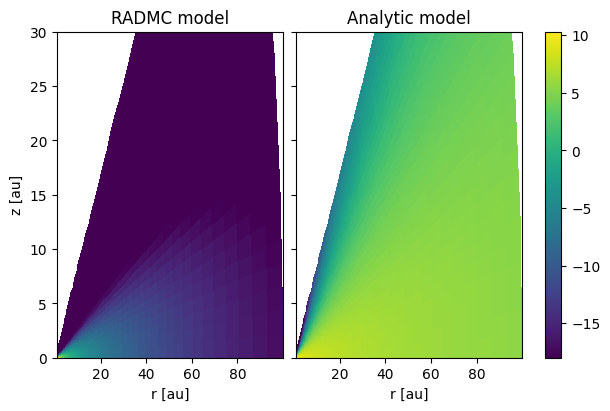

In [30]:
data_in = read_dustdens()
dust_in = data_in.rhodust
dust_in_small = dust_in[:,:,0,0] #grab the 2D of the small dust grains (1% of the mass)
dust_in_large = dust_in[:,:,0,1] #grab the 2D of the large dust grains (99% of mass)

dust_in_small_analytic = rho_hseq*0.01 #predicted small dust distribution 
f,ax = subplots(1,2,constrained_layout=True, sharex=True, sharey=True,dpi=100)
ax[0].pcolormesh(r_mid, z, np.log10(dust_in_small),vmin=-18)
im = ax[1].pcolormesh(r_mid, z, np.log10(dust_in_small_analytic),vmin=-18)
ax[0].set_title('RADMC model')
ax[1].set_title('Analytic model')
ax[0].set_xlabel('r [au]')
ax[1].set_xlabel('r [au]')
ax[0].set_ylabel('z [au]')
ax[0].set_ylim(0,30)
colorbar(im,ax=ax)

### part b
Now that you know what kind of model you're running, let's run the basic thermal transfer!
Once you have those files, you can run the basic radiative transfer calculation by typing ``` radmc3d mctherm``` on the command line. (This might take some time, let it run). After it's done, you should see a new file titled: ```dust_temperature.dat```


In [28]:
os.system('radmc3d mctherm')

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

0

Reading in this file with the functions we loaded in, you can see it returns temperatures for the two dust populations. We can also plot the resulting 2D temperature for the large grains like we did for the dust densities. 

Reading amr_grid.inp
Reading dust_temperature.dat
(64, 32, 1, 2)


/var/folders/ll/nyl1hb0d1kd57xb5xj7nh34m0000gn/T/ipykernel_16023/616824347.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hdr   = np.array(data[:10], dtype=np.int)
/var/folders/ll/nyl1hb0d1kd57xb5xj7nh34m0000gn/T/ipykernel_16023/616824347.py:160: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

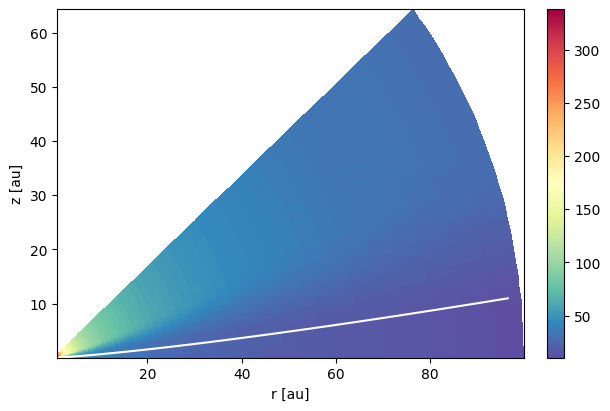

In [32]:
data_out = read_dusttemp()
temp = data_out.dusttemp
print(np.shape(temp))

temp_large = temp[:,:,0,1]
f,ax = subplots(1, dpi=100, constrained_layout=True)
im = ax.pcolormesh(r_mid, z, temp_large,cmap='Spectral_r')
ax.plot(rc,H_init,color='white')
ax.set_xlabel('r [au]')
ax.set_ylabel('z [au]')
colorbar(im,ax=ax)

### part c
Now let's see what we can interpret from the MCMC results! Let's compare these results to the values from your analytic determination. Around where does the temperature best match the analytic estimates? 
Is the analytic temperature an over or underestimate of the midplane temperature value?
Based on what we assume about the optical depth of the radiative temperature profile, what does this tell you about how the dust opacity affects the resulting temperature?

**Menu** Based on the resulting midplane temperature, derive what the new the H/R profile should be.

Text(0, 0.5, 'T [K]')

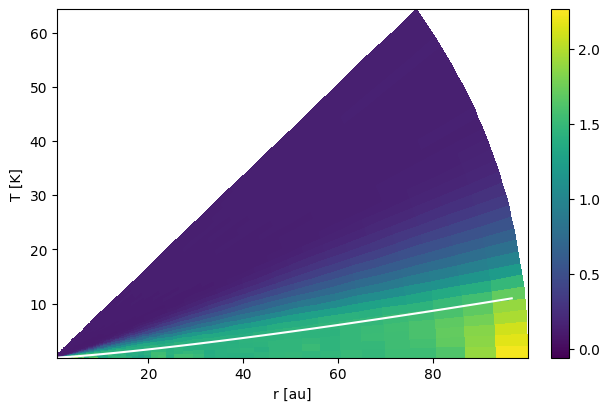

In [33]:
f,ax = subplots(1, dpi=100, constrained_layout=True)

temp_error = np.expand_dims(T_init,axis=1)/temp_large - 1.

im = ax.pcolormesh(r_mid, z, temp_error,cmap='viridis')
ax.plot(rc,H_init,color='white')
ax.set_xlabel('r [au]')
ax.set_ylabel('z [au]')

colorbar(im,ax=ax)

xlabel('r [au]')
ylabel('T [K]')